In [23]:
from sklearn.model_selection import train_test_split as TTS
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import fetch_openml

import numpy as np
import pandas as pd
from sklearn.model_selection import validation_curve

In [11]:
#dataset preparation
from sklearn.datasets import load_wine
wine = load_wine()
X_full, y_full = wine['data'], wine['target']
y_full = y_full.astype(np.uint8)

Xtrain, Xtest, Ytrain, Ytest = TTS(X_full, y_full, test_size=0.3, random_state=1)

In [29]:
X_full.shape, y_full.shape

((178, 13), (178,))

In [189]:
import time
def running_time(estimator, X, Y):
    start = time.time()
    estimator.fit(X, Y)
    end = time.time()
    return end-start

# Decision Tree

In [12]:
# decision trees
tree_clf = tree.DecisionTreeClassifier(criterion='entropy'
                                  , random_state=1
                                  , splitter='random'
                                 )
tree_clf = tree_clf.fit(Xtrain, Ytrain)
score = tree_clf.score(Xtest, Ytest)
score

0.9814814814814815

In [141]:
# learning curve function
def learning_func(estimator, title):
    fig, ax = plt.subplots()

    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=Xtrain, y=Ytrain, cv=20
                                                            , train_sizes=np.r_[0.1:1:20j]
                                                             )

    train_sizes_norm = 100*(train_sizes-train_sizes.min())/(train_sizes.max()-train_sizes.min())


    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)



    # training score
    ax.plot(train_sizes_norm, train_mean, color='blue', marker='o', markersize=5, label='Training score')
    ax.fill_between(train_sizes_norm
                        , train_mean-train_std
                        , train_mean+train_std
                        , alpha=0.1
                        , color='blue'
                        )

    # validation score
    plt.plot(train_sizes_norm, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Cross validation score')
    ax.fill_between(train_sizes_norm
                        , test_mean-test_std
                        , test_mean+test_std
                        , alpha=0.1
                        , color='green'
                        )

    # set fontsize, labelsize
    ax.tick_params(axis='both', size=4, labelsize=14)
    ax.set_xlabel('Sample size, %', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
#     ax.set_ylim(0.55, 1.05)
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.savefig('{}.png'.format(title), dpi=300)

    plt.show()

In [161]:
def valiation_func(estiamtor, param_name, param_range, title):
    train_scores, valid_scores = validation_curve(
    estiamtor,
    Xtest,
    Ytest,
    param_name=param_name, 
    param_range=param_range,
    cv=5
    )
    
    
    fig, ax = plt.subplots()
    ax.plot(param_range, valid_scores.mean(axis=1), marker='o', color='blue', label="{} vs. accuracy".format(param_name))

    # set fontsize, labelsize
    ax.tick_params(axis='both', size=4, labelsize=14)
    ax.set_xlabel('{}'.format(param_name), fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
#     ax.set_xscale("log")
    
    # ax.set_ylim(0.55, 1.05)
    plt.legend(fontsize=12)
#     ax.set_xlim(0, 21)

    plt.tight_layout()

    plt.savefig('valiation {}.png'.format(title), dpi=300)

    plt.show()

In [13]:
# grid search
param_grid = [{'max_depth': [1,2,3,4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
               , 'min_samples_leaf': [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
               , 'min_samples_split': [5, 10, 20, 30, 40, 50]}]
grid_search = GridSearchCV(tree_clf, param_grid, cv=10, scoring='accuracy', return_train_score=True)
grid_search.fit(Xtrain, Ytrain)
tree_clf_gs = grid_search.best_estimator_
tree_clf_gs

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=5,
                       random_state=1, splitter='random')

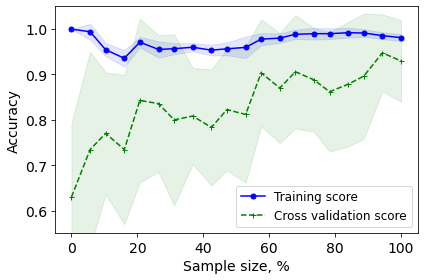

In [19]:
learning_func(tree_clf_gs, 'tree_learning_curve')

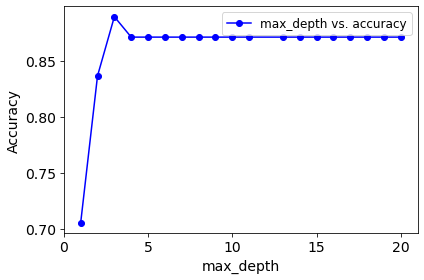

In [27]:
param_name="max_depth"
param_range=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]
valiation_func(tree_clf_gs, param_name, param_range, 'tree_1')

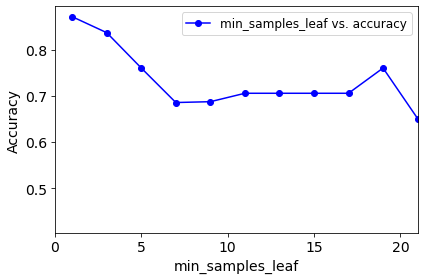

In [28]:
param_name="min_samples_leaf"
param_range=np.arange(1, 50, 2)
valiation_func(tree_clf_gs, param_name, param_range, 'tree_2')

In [190]:
running_time(tree_clf_gs, Xtrain, Ytrain), running_time(tree_clf_gs, Xtest, Ytest), tree_clf_gs.score(Xtest, Ytest)

(0.001984119415283203, 0.0010013580322265625, 0.9814814814814815)

# Neural Network

In [31]:
mlp = MLPClassifier()
param_grid = [{
    'hidden_layer_sizes': [(13,), (13,13), (13,13,13,), (13,13,13,13)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01, 0.05],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [200, 500, 2500, 5000],
}]
grid_search = GridSearchCV(mlp, param_grid, cv=10, scoring='accuracy', return_train_score=True)
grid_search.fit(Xtrain, Ytrain)
mlp_gs = grid_search.best_estimator_
mlp_gs

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TO

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TO

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: St

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.or

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (st

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (st

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: St

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (st

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.or

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (st

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Pyth

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TO

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Opti

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (st

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TO

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TO

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: St

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData

MLPClassifier(activation='logistic', alpha=0.05, hidden_layer_sizes=(13, 13),
              learning_rate='adaptive', max_iter=2500, solver='lbfgs')

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

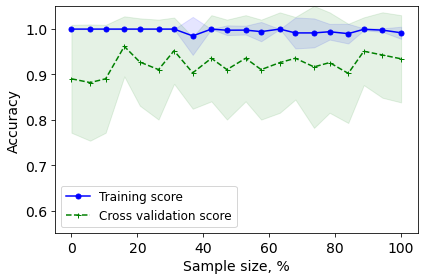

In [32]:
learning_func(mlp_gs, 'mlp_learning_curve')

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

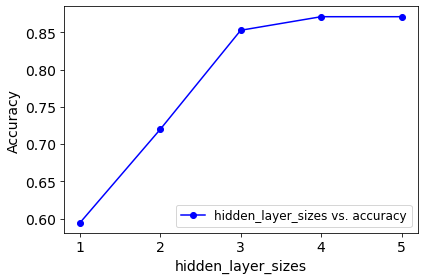

In [36]:
param_name="hidden_layer_sizes"
param_range=[(13,), (13,13), (13,13,13,), (13,13,13,13), (13,13,13,13,13)]
valiation_func(mlp_gs, param_name, np.arange(1, len(param_range)+1), 'nn_1')

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

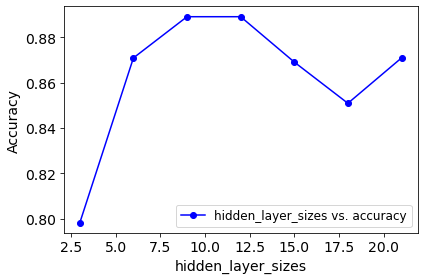

In [37]:
param_name="hidden_layer_sizes"
param_range=[(3,), (6,), (9,), (12,), (15,), (18,), (21,)]
valiation_func(mlp_gs, param_name, param_range, 'nn_2')

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lb

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


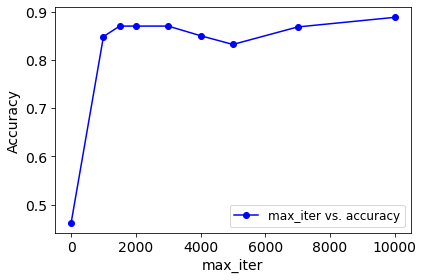

In [38]:
param_name='max_iter'
param_range=[1, 1000, 1500, 2000, 3000, 4000, 5000, 7000, 10000]
valiation_func(mlp_gs, param_name, param_range, 'nn_3')                                      

In [ ]:
# keras for loss curve

In [39]:
mlp_gs

MLPClassifier(activation='logistic', alpha=0.05, hidden_layer_sizes=(13, 13),
              learning_rate='adaptive', max_iter=2500, solver='lbfgs')

In [163]:
X_train, X_valid, Y_train, Y_valid = TTS(Xtrain, Ytrain, test_size=0.2, random_state=1)

nn_model = Sequential()
nn_model.add(tf.keras.Input(shape=(13, 13)))
# nn_model.add(Dense(13, activation='relu'))
nn_model.add(Dense(7, activation='relu'))
nn_model.add(Dense(3, activation='softmax'))

In [164]:
nn_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 13, 7)             98        
_________________________________________________________________
dense_25 (Dense)             (None, 13, 3)             24        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


In [165]:
nn_model.layers

In [166]:
nn_model.compile(loss='binary_crossentropy',
                optimizer='sgd',
                metrics=['accuracy'])

In [167]:
history = nn_model.fit(X_train, Y_train, epochs=1000, validation_data=(X_valid, Y_valid))

Epoch 1/1000
4/4 [==============================] - 0s 27ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 3/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 4/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 5/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 6/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 7/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch

4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 54/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 55/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 56/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 57/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 58/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 59/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 60/1000

4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 111/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 112/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 113/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 114/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 115/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 116/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 1

Epoch 167/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 168/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 169/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 170/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 171/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 172/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 173/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy:

Epoch 224/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 225/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 226/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 227/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 228/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 229/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 230/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy:

Epoch 281/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 282/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 283/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 284/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 285/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 286/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 287/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy:

Epoch 338/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 339/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 340/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 341/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 342/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 343/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 344/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy:

Epoch 395/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 396/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 397/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 398/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 399/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 400/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 401/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy:

Epoch 452/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 453/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 454/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 455/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 456/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 457/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 458/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy:

Epoch 509/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 510/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 511/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 512/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 513/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 514/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 515/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy:

Epoch 566/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 567/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 568/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 569/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 570/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 571/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 572/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy:

Epoch 623/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 624/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 625/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 626/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 627/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 628/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 629/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy:

Epoch 680/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 681/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 682/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 683/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 684/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 685/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 686/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy:

Epoch 737/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 738/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 739/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 740/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 741/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 742/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 743/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy:

Epoch 794/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 795/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 796/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 797/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 798/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 799/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 800/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy:

Epoch 851/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 852/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 853/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 854/1000
4/4 [==============================] - 0s 5ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 855/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 856/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 857/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy:

Epoch 908/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 909/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 910/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 911/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 912/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 913/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 914/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy:

Epoch 965/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 966/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 967/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 968/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 969/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 970/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy: 0.4000
Epoch 971/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.2308 - accuracy: 0.4242 - val_loss: 10.4913 - val_accuracy:

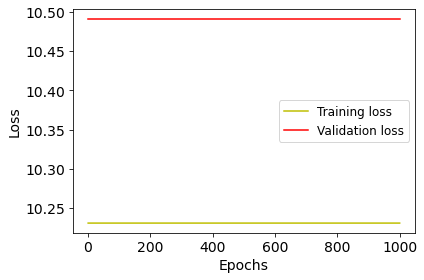

In [168]:
fig, ax = plt.subplots()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
ax.plot(epochs, loss, 'y', label='Training loss')
ax.plot(epochs, val_loss, 'r', label='Validation loss')

# set fontsize, labelsize
ax.tick_params(axis='both', size=4, labelsize=14)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
# ax.set_ylim(0, 5)
plt.legend(fontsize=12)
# ax.set_xlim(1, 500)

plt.tight_layout()

plt.savefig('loss curve.png', dpi=300)

plt.show()

In [191]:
running_time(mlp_gs, Xtrain, Ytrain), running_time(mlp_gs, Xtest, Ytest), mlp_gs.score(Xtest, Ytest)

C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Ruimin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


(1.2143046855926514, 1.0154078006744385, 1.0)

# Adaboosting

In [115]:
ada_clf = AdaBoostClassifier()
param_grid = [{'n_estimators': [50, 100, 150, 200, 300, 400]
               , 'learning_rate': [1.0, 0.1, 0.01, 0.001]
             }]
grid_search = GridSearchCV(ada_clf, param_grid, cv=10, scoring='accuracy', return_train_score=True)
grid_search.fit(Xtrain, Ytrain)
ada_clf_gs = grid_search.best_estimator_
ada_clf_gs

AdaBoostClassifier(learning_rate=0.01)

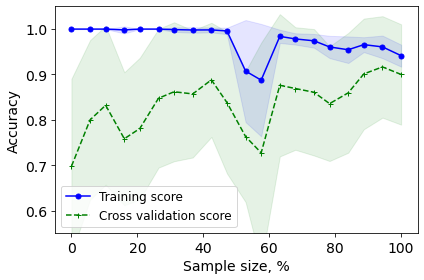

In [116]:
learning_func(ada_clf_gs, 'ada_learning_curve')

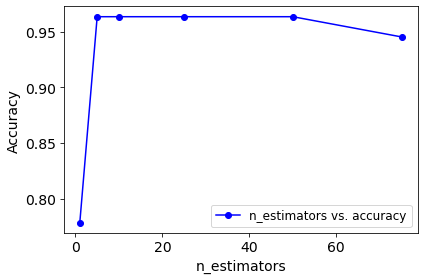

In [125]:
param_name="n_estimators"
param_range=[1, 5, 10, 25, 50, 75]
valiation_func(ada_clf_gs, param_name, param_range, 'ada_1')  

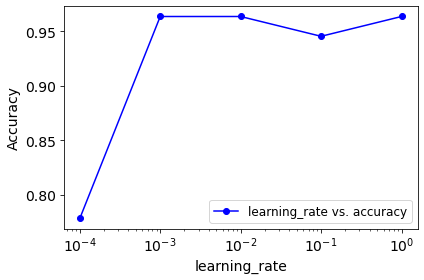

In [130]:
param_name="learning_rate"
param_range=[1.0, 0.1, 0.01, 0.001, 0.0001]
valiation_func(ada_clf_gs, param_name, param_range, 'ada_2')  

In [192]:
running_time(ada_clf_gs, Xtrain, Ytrain), running_time(ada_clf_gs, Xtest, Ytest), ada_clf_gs.score(Xtest, Ytest)

(0.06794500350952148, 0.05398750305175781, 1.0)

# Support Vector Machines

In [156]:
linear_svc_clf = SVC(C=1, kernel='linear')
linear_svc_clf = linear_svc_clf.fit(Xtrain, Ytrain)

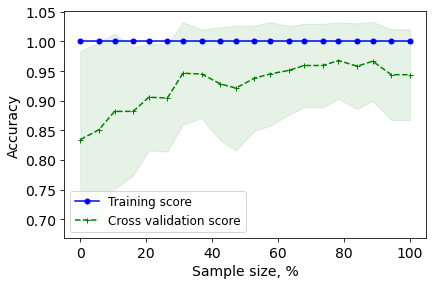

In [157]:
learning_func(linear_svc_clf, 'svc_learning_curve')

In [154]:
nonlinear_svc_clf = SVC(C=1, kernel='rbf')
nonlinear_svc_clf = nonlinear_svc_clf.fit(Xtrain, Ytrain)

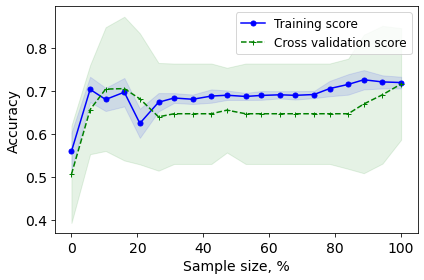

In [155]:
learning_func(nonlinear_svc_clf, 'nonlinear_svc_learning_curve')

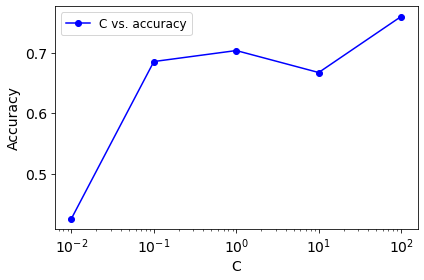

In [139]:
param_name="C"
param_range=[0.01, 0.1, 1, 10, 100]
valiation_func(nonlinear_svc_clf, param_name, param_range, 'svm_1')  

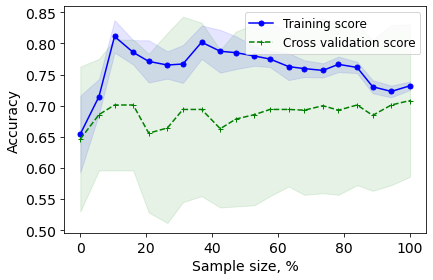

In [145]:
nonlinear_svc_clf = SVC(C=10, kernel='rbf')
nonlinear_svc_clf = nonlinear_svc_clf.fit(Xtrain, Ytrain)
learning_func(nonlinear_svc_clf, 'nonlinear_svc_learning_curve')

In [193]:
running_time(linear_svc_clf, Xtrain, Ytrain), running_time(linear_svc_clf, Xtest, Ytest), linear_svc_clf.score(Xtest, Ytest)

(0.0559537410736084, 0.03098011016845703, 1.0)

In [194]:
running_time(nonlinear_svc_clf, Xtrain, Ytrain), running_time(nonlinear_svc_clf, Xtest, Ytest), nonlinear_svc_clf.score(Xtest, Ytest)

(0.0019826889038085938, 0.0010018348693847656, 0.7407407407407407)

# K-Nearest Neighbors

In [158]:
knn_clf = KNeighborsClassifier()
param_grid = [{'n_neighbors': [2, 3, 4, 5, 6, 7, 8],
               'weights': ['uniform', 'distance'],
               'algorithm': ['ball_tree', 'kd_tree', 'brute'],
               'leaf_size': [10, 20, 30, 40, 50, 60],
               
             }]
grid_search = GridSearchCV(knn_clf, param_grid, cv=10, scoring='accuracy', return_train_score=True)
grid_search.fit(Xtrain, Ytrain)
knn_clf_gs = grid_search.best_estimator_
knn_clf_gs

KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=3)

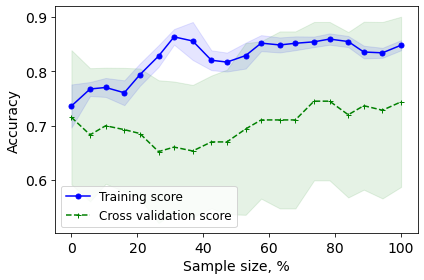

In [159]:
learning_func(knn_clf_gs, 'knn_learning_curve')

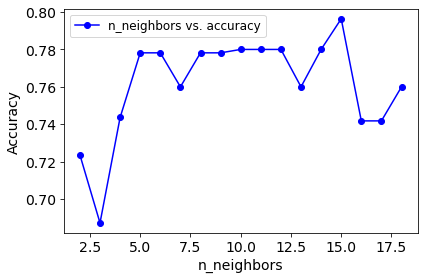

In [175]:
param_name="n_neighbors" 
param_range= np.arange(2, 19)
valiation_func(knn_clf_gs, param_name, param_range, 'knn_1')  

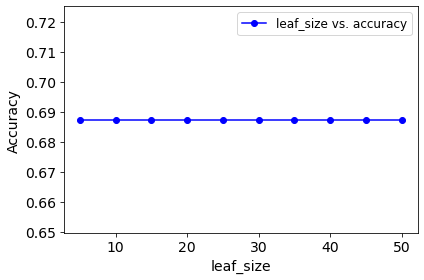

In [174]:
param_name="leaf_size" 
param_range= np.arange(5, 51, 5)
valiation_func(knn_clf_gs, param_name, param_range, 'knn_2')  

In [195]:
running_time(knn_clf_gs, Xtrain, Ytrain), running_time(knn_clf_gs, Xtest, Ytest), knn_clf_gs.score(Xtest, Ytest)

(0.0010099411010742188, 0.0, 0.8518518518518519)

In [196]:
start = time.time()
knn_clf_gs.fit(Xtest, Ytest)
end = time.time()
end-start

0.00099945068359375